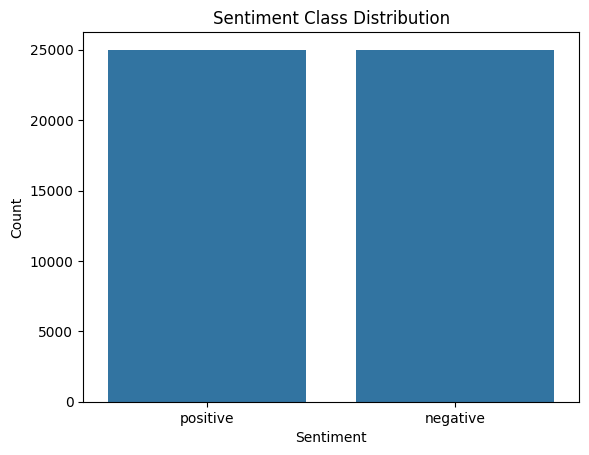

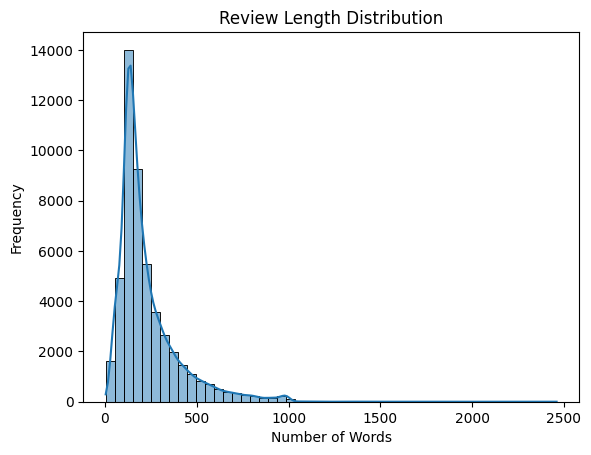

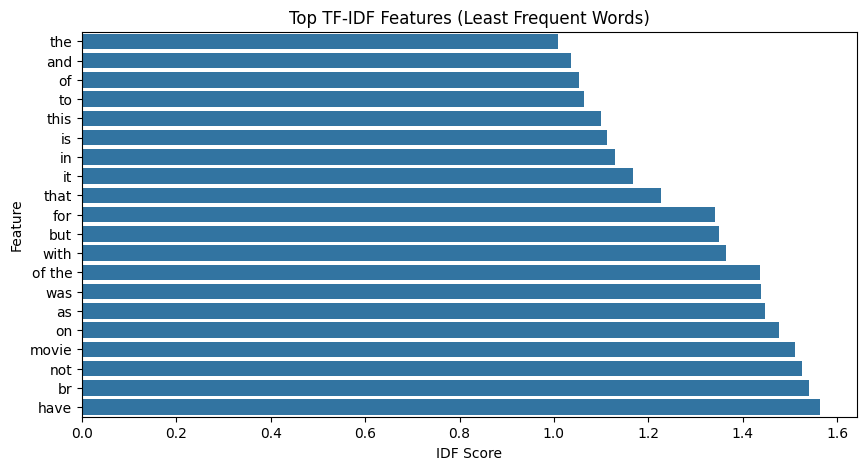


Model: Logistic Regression (Tuned)
Accuracy: 0.9074
Precision: 0.901775147928994
Recall: 0.9144
F1 Score: 0.9080436941410129

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.90      0.91      5000
           1       0.90      0.91      0.91      5000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



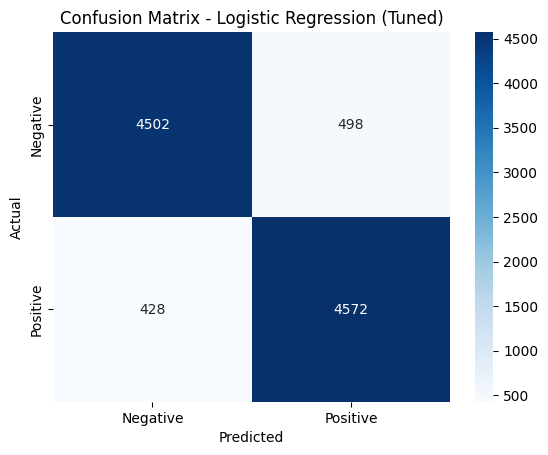


Model: SGDClassifier (Linear SVM)
Accuracy: 0.9027
Precision: 0.8976891171242346
Recall: 0.909
F1 Score: 0.9033091523402564

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.90      0.90      5000
           1       0.90      0.91      0.90      5000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



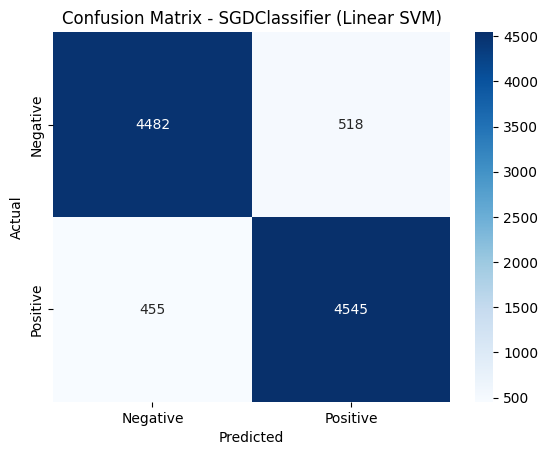


Model: Random Forest
Accuracy: 0.8464
Precision: 0.8248312078019505
Recall: 0.8796
F1 Score: 0.851335656213705

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.81      0.84      5000
           1       0.82      0.88      0.85      5000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



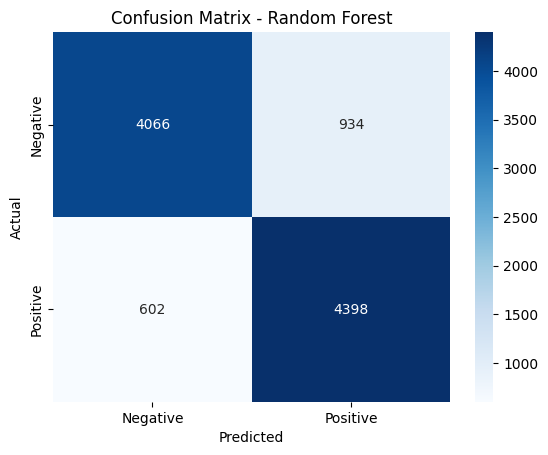


Review: I absolutely loved this movie! The story was amazing and the acting was brilliant.
Logistic Regression Prediction: Positive
SGDClassifier Prediction: Positive
Random Forest Prediction: Positive

Review: Worst movie ever. It was a complete waste of time.
Logistic Regression Prediction: Negative
SGDClassifier Prediction: Negative
Random Forest Prediction: Negative


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import re
import nltk
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

# Load the dataset
file_path = "data/imdb.csv"
df = pd.read_csv(file_path)

# Visualize class distribution
sns.countplot(x='sentiment', data=df)
plt.title("Sentiment Class Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

# Preprocessing function
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    return text

# Apply preprocessing
df['review'] = df['review'].apply(preprocess_text)

# Convert sentiment labels to numeric
df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(df['review'], df['sentiment'], test_size=0.2, random_state=42, stratify=df['sentiment'])

# Show review lengths
review_lengths = df['review'].apply(lambda x: len(x.split()))
sns.histplot(review_lengths, bins=50, kde=True)
plt.title("Review Length Distribution")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()

# TF-IDF vectorization
tfidf = TfidfVectorizer(ngram_range=(1,2), max_features=20000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Visualize top TF-IDF features
def plot_top_tfidf_features(tfidf_vectorizer, top_n=20):
    feature_array = np.array(tfidf_vectorizer.get_feature_names_out())
    tfidf_sorting = np.argsort(tfidf.idf_)
    top_features = feature_array[tfidf_sorting][:top_n]
    top_scores = tfidf.idf_[tfidf_sorting][:top_n]
    plt.figure(figsize=(10,5))
    sns.barplot(x=top_scores, y=top_features)
    plt.title("Top TF-IDF Features (Least Frequent Words)")
    plt.xlabel("IDF Score")
    plt.ylabel("Feature")
    plt.show()

plot_top_tfidf_features(tfidf)

# Save TF-IDF vectorizer
with open("tfidf_vectorizer.pkl", "wb") as f:
    pickle.dump(tfidf, f)

# Hyperparameter tuning for Logistic Regression
log_reg = LogisticRegression()
param_grid_log = {'C': [0.1, 0.5, 1, 2]}
gs_log = GridSearchCV(log_reg, param_grid_log, cv=3, scoring='f1')
gs_log.fit(X_train_tfidf, y_train)
log_reg_best = gs_log.best_estimator_
y_pred_log = log_reg_best.predict(X_test_tfidf)

# Replace SVC with SGDClassifier (linear SVM alternative)
svm_best = SGDClassifier(loss='hinge', max_iter=1000, tol=1e-3, random_state=42)
svm_best.fit(X_train_tfidf, y_train)
y_pred_svm = svm_best.predict(X_test_tfidf)

# Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, max_depth=20, random_state=42)
rf.fit(X_train_tfidf, y_train)
y_pred_rf = rf.predict(X_test_tfidf)

# Save models
with open("logistic_regression.pkl", "wb") as f:
    pickle.dump(log_reg_best, f)
with open("svm_model.pkl", "wb") as f:
    pickle.dump(svm_best, f)
with open("random_forest.pkl", "wb") as f:
    pickle.dump(rf, f)

# Evaluation function
def evaluate_model(y_true, y_pred, model_name):
    print(f"\nModel: {model_name}")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall:", recall_score(y_true, y_pred))
    print("F1 Score:", f1_score(y_true, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# Evaluate models
evaluate_model(y_test, y_pred_log, "Logistic Regression (Tuned)")
evaluate_model(y_test, y_pred_svm, "SGDClassifier (Linear SVM)")
evaluate_model(y_test, y_pred_rf, "Random Forest")

# Predict sentiment
def predict_sentiment(new_reviews):
    with open("tfidf_vectorizer.pkl", "rb") as f:
        tfidf = pickle.load(f)
    with open("logistic_regression.pkl", "rb") as f:
        log_reg = pickle.load(f)
    with open("svm_model.pkl", "rb") as f:
        svm = pickle.load(f)
    with open("random_forest.pkl", "rb") as f:
        rf = pickle.load(f)

    new_reviews_cleaned = [preprocess_text(review) for review in new_reviews]
    new_reviews_tfidf = tfidf.transform(new_reviews_cleaned)

    pred_log = log_reg.predict(new_reviews_tfidf)
    pred_svm = svm.predict(new_reviews_tfidf)
    pred_rf = rf.predict(new_reviews_tfidf)

    for review, p1, p2, p3 in zip(new_reviews, pred_log, pred_svm, pred_rf):
        print(f"\nReview: {review}")
        print(f"Logistic Regression Prediction: {'Positive' if p1 == 1 else 'Negative'}")
        print(f"SGDClassifier Prediction: {'Positive' if p2 == 1 else 'Negative'}")
        print(f"Random Forest Prediction: {'Positive' if p3 == 1 else 'Negative'}")

# Example predictions
new_reviews = [
    "I absolutely loved this movie! The story was amazing and the acting was brilliant.",
    "Worst movie ever. It was a complete waste of time."
]
predict_sentiment(new_reviews)


In [2]:
new_reviews = [
    "Delighting in razzle-dazzle over historical precision, Gladiator II rigorously entertains all the better for it.",  "Echoing its predecessor while upping the bloodsport and camp, Gladiator II is an action extravaganza that derives much of its strength and honor from Denzel Washington's scene-stealing performance.",
    "Watching Gladiator II, it is hard not to be a little suspicious about exactly what we are longing for in our Roman fantasies."
]
predict_sentiment(new_reviews)


Review: Delighting in razzle-dazzle over historical precision, Gladiator II rigorously entertains all the better for it.
Logistic Regression Prediction: Negative
SGDClassifier Prediction: Negative
Random Forest Prediction: Positive

Review: Echoing its predecessor while upping the bloodsport and camp, Gladiator II is an action extravaganza that derives much of its strength and honor from Denzel Washington's scene-stealing performance.
Logistic Regression Prediction: Positive
SGDClassifier Prediction: Positive
Random Forest Prediction: Positive

Review: Watching Gladiator II, it is hard not to be a little suspicious about exactly what we are longing for in our Roman fantasies.
Logistic Regression Prediction: Positive
SGDClassifier Prediction: Positive
Random Forest Prediction: Positive
